In [1]:
import findspark
findspark.init()
findspark.find()
import pyspark
from pyspark.sql import SparkSession, SQLContext
from pyspark.ml import Pipeline,Transformer
from pyspark.ml.feature import Imputer,StandardScaler,StringIndexer,OneHotEncoder, VectorAssembler

from pyspark.sql.functions import col, SparkContext, udf
from pyspark.sql.types import *
import numpy as np

In [2]:
appName = "Big Data ML"
master = "local"

# Create Configuration object for Spark.
conf = pyspark.SparkConf()\
    .set('spark.driver.host','127.0.0.1')\
    .setAppName(appName)\
    .setMaster(master)

# Create Spark Context with the new configurations rather than relying on the default one
sc = SparkContext.getOrCreate(conf=conf)

# You need to create SQL Context to conduct some database operations like what we will see later.
sqlContext = SQLContext(sc)

# If you have SQL context, you create the session from the Spark Context
# spark = sqlContext.sparkSession.builder.getOrCreate()
spark = sqlContext.sparkSession.builder.getOrCreate()

C:\Users\Brandon\AppData\Local\Programs\Python\Python311\Lib\site-packages\pyspark\sql\context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


In [3]:
mqtt_raw = spark.read.csv("train70_reduced.csv",header=True, inferSchema= True)
mqtt_test_raw = spark.read.csv("test30_reduced.csv",header=True, inferSchema= True)

# Rename columns
for column_name in mqtt_raw.columns:
    new_column_name = column_name.replace(".", "_")
    mqtt_raw = mqtt_raw.withColumnRenamed(column_name, new_column_name)

for column_name in mqtt_test_raw.columns:
    new_column_name = column_name.replace(".", "_")
    mqtt_test_raw = mqtt_test_raw.withColumnRenamed(column_name, new_column_name)

# Drop the few rows with NA values (only 190)
mqtt_raw = mqtt_raw.na.drop()
mqtt_test_raw = mqtt_test_raw.na.drop()

# Dropping a couple useless columns
mqtt_raw = mqtt_raw.drop("mqtt_protoname")
mqtt_test_raw = mqtt_test_raw.drop("mqtt_protoname")

# Converting nominal columns to string so they can be encoded by the transformer 
# mqtt_raw = mqtt_raw.withColumn("mqtt_msgtype", mqtt_raw["mqtt_msgtype"].cast("string"))
# mqtt_raw = mqtt_raw.withColumn("mqtt_conack_val", mqtt_raw["mqtt_conack_val"].cast("string"))
# mqtt_test_raw = mqtt_test_raw.withColumn("mqtt_msgtype", mqtt_test_raw["mqtt_msgtype"].cast("string"))
# mqtt_test_raw = mqtt_test_raw.withColumn("mqtt_conack_val", mqtt_test_raw["mqtt_conack_val"].cast("string"))

In [4]:
mqtt_raw.printSchema()

root
 |-- tcp_flags: string (nullable = true)
 |-- tcp_time_delta: double (nullable = true)
 |-- tcp_len: integer (nullable = true)
 |-- mqtt_conack_flags: string (nullable = true)
 |-- mqtt_conack_flags_reserved: double (nullable = true)
 |-- mqtt_conack_flags_sp: double (nullable = true)
 |-- mqtt_conack_val: double (nullable = true)
 |-- mqtt_conflag_cleansess: double (nullable = true)
 |-- mqtt_conflag_passwd: double (nullable = true)
 |-- mqtt_conflag_qos: double (nullable = true)
 |-- mqtt_conflag_reserved: double (nullable = true)
 |-- mqtt_conflag_retain: double (nullable = true)
 |-- mqtt_conflag_uname: double (nullable = true)
 |-- mqtt_conflag_willflag: double (nullable = true)
 |-- mqtt_conflags: string (nullable = true)
 |-- mqtt_dupflag: double (nullable = true)
 |-- mqtt_hdrflags: string (nullable = true)
 |-- mqtt_kalive: double (nullable = true)
 |-- mqtt_len: double (nullable = true)
 |-- mqtt_msg: string (nullable = true)
 |-- mqtt_msgid: double (nullable = true)
 |-

In [5]:
col_names =  ["tcp_flags","tcp_time_delta","tcp_len",
"mqtt_conack_flags","mqtt_conack_flags_reserved","mqtt_conack_flags_sp",
"mqtt_conack_val","mqtt_conflag_cleansess","mqtt_conflag_passwd",
"mqtt_conflag_qos","mqtt_conflag_reserved","mqtt_conflag_retain",
"mqtt_conflag_uname","mqtt_conflag_willflag",
"mqtt_conflags","mqtt_dupflag","mqtt_hdrflags",
"mqtt_kalive","mqtt_len","mqtt_msg","mqtt_msgid","mqtt_msgtype",
"mqtt_proto_len","mqtt_qos",
"mqtt_retain","mqtt_sub_qos","mqtt_suback_qos","mqtt_ver",
"mqtt_willmsg","mqtt_willmsg_len","mqtt_willtopic","mqtt_willtopic_len",
"target"]

nominal_cols = ["mqtt_msgtype", "mqtt_conack_val", "tcp_flags", "mqtt_hdrflags"]
binary_cols = ["mqtt_dupflag"]
continuous_cols = ["tcp_time_delta","tcp_len",
"mqtt_conack_flags_reserved","mqtt_conack_flags_sp",
"mqtt_conflag_cleansess","mqtt_conflag_passwd",
"mqtt_conflag_qos","mqtt_conflag_reserved","mqtt_conflag_retain",
"mqtt_conflag_uname","mqtt_conflag_willflag",
"mqtt_kalive","mqtt_len","mqtt_msg","mqtt_msgid",
"mqtt_proto_len","mqtt_qos",
"mqtt_retain","mqtt_sub_qos","mqtt_suback_qos","mqtt_ver",
"mqtt_willmsg","mqtt_willmsg_len","mqtt_willtopic","mqtt_willtopic_len",
"mqtt_conack_flags", "mqtt_conflags"]

In [6]:
#Not sure if we should drop "mqtt_hdrflags"
columns_to_drop = ["mqtt_msg", "mqtt_conack_flags", "mqtt_conflags", 
"mqtt_willtopic_len", "mqtt_willtopic", "mqtt_willmsg_len", "mqtt_willmsg",
"mqtt_suback_qos", "mqtt_sub_qos", "mqtt_conflag_willflag", "mqtt_conflag_retain",
"mqtt_conflag_reserved", "mqtt_conflag_qos", "mqtt_conack_flags_sp", 
"mqtt_conack_flags_reserved"] # Add any columns that we want to just get rid of here

In [7]:
nominal_id_cols = [x+"_index" for x in nominal_cols]
nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)
# Stage where the index columns are further transformed using OneHotEncoder
stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

indexer_model = stage_nominal_indexer.fit(mqtt_raw)
mqtt_raw_indx = indexer_model.transform(mqtt_raw)
encoder_model = stage_nominal_onehot_encoder.fit(mqtt_raw_indx)
mqtt_encoded = encoder_model.transform(mqtt_raw_indx)

In [8]:
c = "mqtt_hdrflags"
mqtt_raw_indx.select(c+"_index").distinct().show()
mqtt_encoded.select(c+"_encoded").distinct().show()

+-------------------+
|mqtt_hdrflags_index|
+-------------------+
|                8.0|
|                0.0|
|                7.0|
|                1.0|
|                4.0|
|               11.0|
|                3.0|
|                2.0|
|               10.0|
|               13.0|
|                6.0|
|                5.0|
|                9.0|
|               12.0|
+-------------------+

+---------------------+
|mqtt_hdrflags_encoded|
+---------------------+
|           (13,[],[])|
|       (13,[4],[1.0])|
|       (13,[2],[1.0])|
|       (13,[6],[1.0])|
|      (13,[11],[1.0])|
|       (13,[7],[1.0])|
|      (13,[12],[1.0])|
|       (13,[5],[1.0])|
|       (13,[9],[1.0])|
|       (13,[0],[1.0])|
|       (13,[1],[1.0])|
|       (13,[3],[1.0])|
|       (13,[8],[1.0])|
|      (13,[10],[1.0])|
+---------------------+



In [9]:
mqtt_raw.show(1,vertical=True)

-RECORD 0--------------------------------
 tcp_flags                  | 0x00000018 
 tcp_time_delta             | 0.998867   
 tcp_len                    | 10         
 mqtt_conack_flags          | 0          
 mqtt_conack_flags_reserved | 0.0        
 mqtt_conack_flags_sp       | 0.0        
 mqtt_conack_val            | 0.0        
 mqtt_conflag_cleansess     | 0.0        
 mqtt_conflag_passwd        | 0.0        
 mqtt_conflag_qos           | 0.0        
 mqtt_conflag_reserved      | 0.0        
 mqtt_conflag_retain        | 0.0        
 mqtt_conflag_uname         | 0.0        
 mqtt_conflag_willflag      | 0.0        
 mqtt_conflags              | 0          
 mqtt_dupflag               | 0.0        
 mqtt_hdrflags              | 0x00000030 
 mqtt_kalive                | 0.0        
 mqtt_len                   | 8.0        
 mqtt_msg                   | 32         
 mqtt_msgid                 | 0.0        
 mqtt_msgtype               | 3.0        
 mqtt_proto_len             | 0.0 

In [10]:
from pyspark.sql.functions import when, isnan
nan_col = [col(column) for column in mqtt_raw.columns]
nan_val = mqtt_raw.select(*nan_col).select(*[
    when(isnan(col(c)), c).alias(c) for c in mqtt_raw.columns
])

print(nan_val.count())
print(mqtt_raw.count())

231646
231646


In [11]:
'''
Data preprocessing pipeline
'''
class OutcomeCreater(Transformer): # this defines a transformer that creates the outcome column
    def __init__(self):
        super().__init__()

    def label_to_vector(self, name):
        name = name.lower()
        
        if name == 'legitimate':
            return 0.0
        elif name == 'dos':
            return 1.0
        elif name == 'malformed':
            return 2.0
        elif name == 'slowite':
            return 3.0
        elif name == 'bruteforce':
            return 4.0
        elif name == 'flood':
            return 5.0
        else:
            return -100.0

    def _transform(self, dataset):
        label_to_vector_udf = udf(self.label_to_vector, StringType())
        output_df = dataset.withColumn('outcome', label_to_vector_udf(col('target'))).drop("target")  
        output_df = output_df.withColumn('outcome', col('outcome').cast(DoubleType()))
        return output_df

class FeatureTypeCaster(Transformer): # this transformer will cast the columns as appropriate types  
    def __init__(self, targetCols):
        super().__init__()
        self.target_cols = targetCols

    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.target_cols:
            output_df = output_df.withColumn(col_name,col(col_name).cast(DoubleType()))

        return output_df

class ColumnDropper(Transformer): # this transformer drops unnecessary columns
    def __init__(self, columns_to_drop = None):
        super().__init__()
        self.columns_to_drop=columns_to_drop
    def _transform(self, dataset):
        output_df = dataset
        for col_name in self.columns_to_drop:
            output_df = output_df.drop(col_name)
        return output_df

def get_preprocess_pipeline():
    # Stage where columns are casted as appropriate types
    impute_columns = binary_cols+continuous_cols
    for col_name in columns_to_drop:
        if col_name in impute_columns:
            impute_columns.remove(col_name)
    stage_typecaster = FeatureTypeCaster(impute_columns)

    # Stage where coulmns are imputed if they have NAs
    stage_imputer = Imputer(inputCols=impute_columns, outputCols=impute_columns)

    # Stage where nominal columns are transformed to index columns using StringIndexer
    nominal_id_cols = [x+"_index" for x in nominal_cols]
    nominal_onehot_cols = [x+"_encoded" for x in nominal_cols]
    stage_nominal_indexer = StringIndexer(inputCols=nominal_cols, outputCols=nominal_id_cols)

    # Stage where the index columns are further transformed using OneHotEncoder
    stage_nominal_onehot_encoder = OneHotEncoder(inputCols=nominal_id_cols, outputCols=nominal_onehot_cols)

    # Stage where all relevant features are assembled into a vector (and dropping a few)
    feature_cols = impute_columns+nominal_onehot_cols
    for col_name in columns_to_drop:
        if col_name in nominal_cols:
            feature_cols.remove(col_name+"_encoded")
            feature_cols.remove(col_name+"_index")
    stage_vector_assembler = VectorAssembler(inputCols=feature_cols, outputCol="vectorized_features")

    # Stage where we scale the columns
    stage_scaler = StandardScaler(inputCol= 'vectorized_features', outputCol= 'features')

    # Stage for creating the outcome column representing whether there is attack 
    stage_outcome = OutcomeCreater()

    # Removing all unnecessary columbs, only keeping the 'features' and 'outcome' columns
    stage_column_dropper = ColumnDropper(columns_to_drop = nominal_cols + nominal_id_cols + nominal_onehot_cols +
        binary_cols + continuous_cols + columns_to_drop + ['vectorized_features'])
    # stage_column_dropper = ColumnDropper(columns_to_drop = nominal_id_cols + columns_to_drop + ['vectorized_features'])
    # Connect the columns into a pipeline
    pipeline = Pipeline(stages=[stage_typecaster, stage_imputer, stage_nominal_indexer, stage_nominal_onehot_encoder,
        stage_vector_assembler, stage_scaler, stage_outcome, stage_column_dropper])
    return pipeline

In [12]:
preprocess_pipeline = get_preprocess_pipeline()
preprocess_pipeline_model = preprocess_pipeline.fit(mqtt_raw)

mqtt_df = preprocess_pipeline_model.transform(mqtt_raw)
mqtt_df_test = preprocess_pipeline_model.transform(mqtt_test_raw)

In [13]:
from pyspark.sql.functions import when, isnan
nan_col = [col(column) for column in mqtt_raw.columns]
nan_val = mqtt_raw.select(*nan_col).select(*[
    when(isnan(col(c)), c).alias(c) for c in mqtt_raw.columns
])

nan_val.show(vertical=True)

-RECORD 0--------------------------
 tcp_flags                  | null 
 tcp_time_delta             | null 
 tcp_len                    | null 
 mqtt_conack_flags          | null 
 mqtt_conack_flags_reserved | null 
 mqtt_conack_flags_sp       | null 
 mqtt_conack_val            | null 
 mqtt_conflag_cleansess     | null 
 mqtt_conflag_passwd        | null 
 mqtt_conflag_qos           | null 
 mqtt_conflag_reserved      | null 
 mqtt_conflag_retain        | null 
 mqtt_conflag_uname         | null 
 mqtt_conflag_willflag      | null 
 mqtt_conflags              | null 
 mqtt_dupflag               | null 
 mqtt_hdrflags              | null 
 mqtt_kalive                | null 
 mqtt_len                   | null 
 mqtt_msg                   | null 
 mqtt_msgid                 | null 
 mqtt_msgtype               | null 
 mqtt_proto_len             | null 
 mqtt_qos                   | null 
 mqtt_retain                | null 
 mqtt_sub_qos               | null 
 mqtt_suback_qos            

In [14]:
mqtt_df_test.printSchema()

root
 |-- features: vector (nullable = true)
 |-- outcome: double (nullable = true)



In [15]:
mqtt_df_test.select("features").show(2, vertical=True, truncate=False)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 features | (44,[1,14,23,31],[0.010291756936844065,2.0647113976609544,15.170003569347903,2.0647113976609544])                                                                                                                               
-RECORD 1-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 features | (44,[0,1,2,7,8,10,13,23,24,35],[4.487015133212843,3.4473628112963306E-7,0.053824635906756645,2.7890577143082704,2.52808766770505,2.707404671193102,2.0022560887606677,15.170003569347903,2.0128584380147863,4.487015133212843]) 
only showing top 2 rows



In [16]:
mqtt_df_test.show(2, truncate=False, vertical=True)

-RECORD 0-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 features | (44,[1,14,23,31],[0.010291756936844065,2.0647113976609544,15.170003569347903,2.0647113976609544])                                                                                                                               
 outcome  | 2.0                                                                                                                                                                                                                             
-RECORD 1-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
 features | (44,[0,1,2,7,8,10,13,23,24,35],[4.487015

In [17]:
#Model 1 - Logistic Regression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier

lr = LogisticRegression(featuresCol = 'features', labelCol = 'outcome')
lrModel = lr.fit(mqtt_df) 

In [18]:
from pyspark.ml.classification import RandomForestClassifier

rfc = RandomForestClassifier(featuresCol = 'features', labelCol = 'outcome')
rf_model = rfc.fit(mqtt_df)

In [19]:
pred_LR = lrModel.transform(mqtt_df_test)
y_pred = pred_LR.select('outcome').collect()
y = mqtt_df_test.select('outcome').collect()
correct = 0
for i in range(len(y)):
    if y[i][0]==y_pred[i][0]:
        correct += 1
print("LR Test Accuracy:",correct/len(y)*100, "%")

LR Test Accuracy: 100.0 %


In [20]:
pred_DT = rf_model.transform(mqtt_df_test)
y_pred_DT = pred_DT.select('outcome').collect()
correct = 0
for i in range(len(y)):
    if y[i][0]==y_pred_DT[i][0]:
        correct += 1
print("DT Test Accuracty:",correct/len(y)*100, "%")

DT Test Accuracty: 100.0 %


Pytorch Learning 

In [32]:
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn, optim

import matplotlib.pyplot as plt

In [21]:
mqtt_df_val, mqtt_df_test = mqtt_df_test.randomSplit([0.5, 0.5])

In [24]:
mqtt_df_val_pd = mqtt_df_val.toPandas()
mqtt_df_train_pd = mqtt_df.toPandas()
mqtt_df_test_pd = mqtt_df_test.toPandas()

In [27]:
x_train = torch.from_numpy(np.array(mqtt_df_train_pd['features'].values.tolist(),np.float32))
y_train = torch.from_numpy(np.array(mqtt_df_train_pd['outcome'].values.tolist(),np.int64))

x_test = torch.from_numpy(np.array(mqtt_df_test_pd['features'].values.tolist(),np.float32))
y_test = torch.from_numpy(np.array(mqtt_df_test_pd['outcome'].values.tolist(),np.int64))

x_val = torch.from_numpy(np.array(mqtt_df_val_pd['features'].values.tolist(),np.float32))
y_val = torch.from_numpy(np.array(mqtt_df_val_pd['outcome'].values.tolist(),np.int64))

In [28]:
class MyDataset(Dataset):
    def __init__(self,x,y):
        self.x = x
        self.y = y

    def __len__(self):
        return self.x.shape[0]

    def __getitem__(self,idx):
        return(self.x[idx],self.y[idx])

train_dataset = MyDataset(x_train,y_train)
validate_dataset = MyDataset(x_val,y_val)
test_dataset = MyDataset(x_test,y_test)

In [29]:
class NeuralNet(nn.Module):
    def __init__(self, input_size=2, output_size=1, hidden_layer_sizes=[24,24], activation_func = nn.ReLU):
        super().__init__()

        layers = []                                               # List of layers
        layers.append(nn.Linear(input_size,hidden_layer_sizes[0]))         # First hidden layer

                                                                  # Next hidden layers
        for i in range(len(hidden_layer_sizes)-1):
            layers.append(activation_func())
            layers.append(nn.Linear(hidden_layer_sizes[i],hidden_layer_sizes[i+1]))
            
        layers.append(activation_func())                                  # Output layer (if needed)
        layers.append(nn.Linear(hidden_layer_sizes[-1], output_size))
        
        self.seq = nn.Sequential(*layers)                         # Final sequential model

    def forward(self, xy):
        return self.seq(xy)

In [48]:
def train(model, train_data, val_data, lr = 0.01, epochs = 1000, batch_size=32, gamma = 1):
    # Define loss, optimizer, and scheduler
    lossfun = nn.functional.cross_entropy
    opt = optim.SGD(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.ExponentialLR(optimizer=opt, gamma=gamma)

    # Define data loaders to do batch decent
    train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)

    train_loss_hist = []
    val_loss_hist = []
    train_acc_hist = []
    val_acc_hist = []
    batch_loss_hist = []
    best_acc = 0.0
    for epoch in range(epochs+1):

        # Training batch loop for this epoch
        train_batch_loss=[]
        train_batch_acc=[]
        model.train()
        for _, (x_batch, y_batch) in enumerate(train_dataloader):
            test_batch_pred = model(x_batch)
            loss_train = lossfun(test_batch_pred, y_batch)
            
            opt.zero_grad()
            loss_train.backward()
            opt.step()

            train_batch_loss.append(loss_train.detach())
            test_batch_label = np.argmax(test_batch_pred.detach(), axis=1).numpy()
            train_batch_acc.append(np.sum(test_batch_label == y_batch.numpy())/y_batch.shape[0])

        # Validation batch loop for this epoch
        val_batch_loss = []
        val_batch_acc=[]
        model.eval()
        for _, (x_batch_val, y_batch_val) in enumerate(val_dataloader):
            val_batch_pred = model(x_batch_val)
            loss_val = lossfun(val_batch_pred, y_batch_val)

            val_batch_loss.append(loss_val.detach())
            val_batch_label = np.argmax(val_batch_pred.detach(), axis=1).numpy()
            val_batch_acc.append(np.sum(val_batch_label == y_batch_val.numpy())/y_batch_val.shape[0])

        scheduler.step()

        # Save data to histories
        batch_loss_hist += train_batch_loss
        train_loss_hist.append(np.mean(train_batch_loss))
        val_loss_hist.append(np.mean(val_batch_loss))
        train_acc_hist.append(np.mean(train_batch_acc))
        val_acc_hist.append(np.mean(val_batch_acc))

        # Print epoch info
        # print(f"Epoch {epoch:>4} of {epochs}:   Train Loss = {   train_loss_hist[-1]:.3f}   Validation Loss = {   val_loss_hist[-1]:.3f}"+
        #                                    f"   Train Acc  = {100*train_acc_hist[-1]:.3f}   Validation Acc  = {100*val_acc_hist[-1]:.3f}")

        # Save model if it is the best so far
        if val_acc_hist[-1] > best_acc:
            torch.save(model.state_dict(), 'current_best_model')
            best_acc = val_acc_hist[-1]

    # plt.figure(figsize=(4,2),dpi=250)
    # plt.plot(batch_loss_hist)
    # plt.xlabel("Batch")
    # plt.ylabel("Loss")
    # plt.title("Loss across all batches")
    # plt.show()

    # fig, axs = plt.subplots(1,2)
    # axs[0].plot(train_loss_hist,label="Training")
    # axs[0].plot(val_loss_hist,label="Validation")
    # axs[0].legend()
    # axs[0].set_xlabel("Epoch")
    # axs[0].set_ylabel("Loss")
    # axs[0].set_title("Loss across Epochs")

    # axs[1].plot(train_acc_hist,label="Training")
    # axs[1].plot(val_acc_hist,label="Validation")
    # axs[1].legend()
    # axs[1].set_xlabel("Epoch")
    # axs[1].set_ylabel("Accuracy")
    # axs[1].set_title("Accuracy across Epochs")
    # plt.show()

    return

NeuralNet(
  (seq): Sequential(
    (0): Linear(in_features=44, out_features=64, bias=True)
    (1): RReLU(lower=0.125, upper=0.3333333333333333)
    (2): Linear(in_features=64, out_features=6, bias=True)
  )
)
Epoch    0 of 20:   Train Loss = 0.441   Validation Loss = 0.435   Train Acc  = 81.747   Validation Acc  = 82.249
Epoch    1 of 20:   Train Loss = 0.419   Validation Loss = 0.423   Train Acc  = 82.697   Validation Acc  = 83.287
Epoch    2 of 20:   Train Loss = 0.417   Validation Loss = 0.420   Train Acc  = 82.786   Validation Acc  = 83.299
Epoch    3 of 20:   Train Loss = 0.416   Validation Loss = 0.418   Train Acc  = 82.784   Validation Acc  = 82.964
Epoch    4 of 20:   Train Loss = 0.416   Validation Loss = 0.416   Train Acc  = 82.825   Validation Acc  = 83.299
Epoch    5 of 20:   Train Loss = 0.416   Validation Loss = 0.419   Train Acc  = 82.780   Validation Acc  = 82.771
Epoch    6 of 20:   Train Loss = 0.415   Validation Loss = 0.419   Train Acc  = 82.822   Validation Acc  

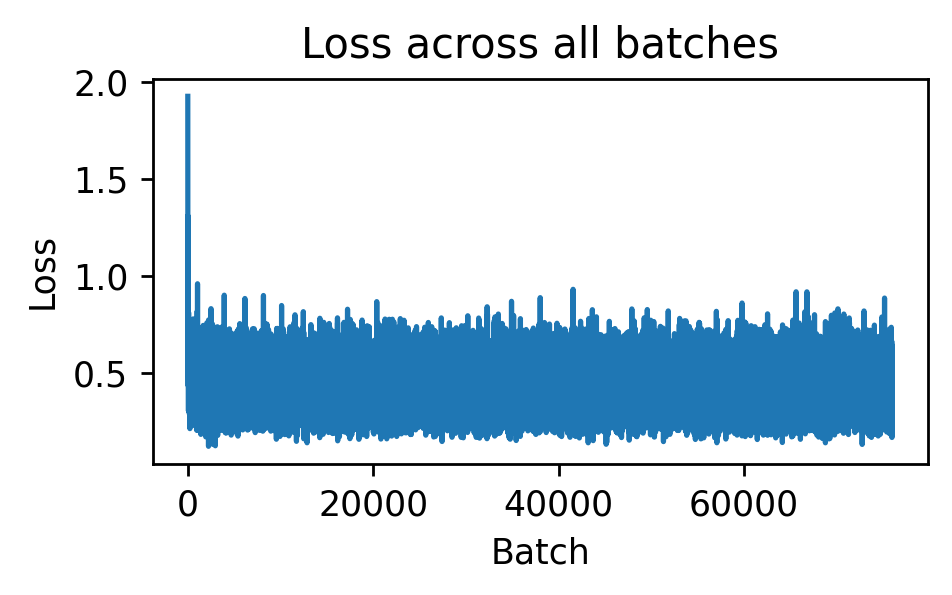

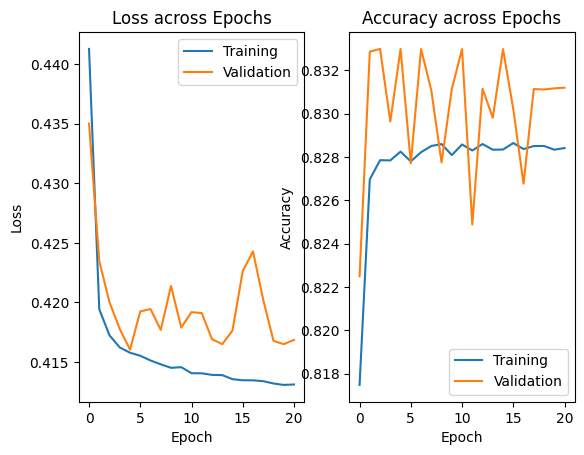

In [43]:
hidden_layers = [64]
activation = nn.RReLU
net = NeuralNet(input_size=x_train.shape[1], output_size=6, hidden_layer_sizes=hidden_layers, activation_func=activation)
print(net)
train(net, train_dataset, validate_dataset, lr=0.05, epochs=20, batch_size=64, gamma=1)

In [44]:
best_model = NeuralNet(input_size=x_train.shape[1], output_size=6, hidden_layer_sizes=hidden_layers, activation_func=activation)
best_model.load_state_dict(torch.load("current_best_model"))

prediction = np.argmax(best_model(x_test).detach(), axis=1).numpy()
accuracy = 100*np.sum(prediction == y_test.numpy())/y_test.shape[0]
print(f"Testing accuracy: {accuracy:.2f}%")

Testing accuracy: 82.77%


In [ ]:
num_nodes = [8,16,32,64,128]
layer_combos = [[1],[1,1],[1,1,1]]
LRs = [0.001, 0.005, 0.001, 0.005, 0.01, 0.05]
epochs = [5, 10, 15, 20]
activations =[nn.RReLU, nn.GELU]

best_accuracy = 0
best_layers = []
best_LR = 0
best_epoch = 0
best_activation = nn.SiLU
for n in num_nodes:
    for layers in layer_combos:
        l = [x*n for x in layers]
        for LR in LRs:
            for a in activations:
                for e in epochs:
                    m = NeuralNet(input_size=x_train.shape[1], output_size=6, hidden_layer_sizes=l, activation_func=a)
                    train(m, train_dataset, validate_dataset, lr=LR, epochs=e, batch_size=64, gamma=1)
                    best_model = NeuralNet(input_size=x_train.shape[1], output_size=6, hidden_layer_sizes=l, activation_func=a)
                    best_model.load_state_dict(torch.load("current_best_model"))
                    
                    prediction = np.argmax(best_model(x_test).detach(), axis=1).numpy()
                    accuracy = 100*np.sum(prediction == y_test.numpy())/y_test.shape[0]
                                    
                    if accuracy > best_accuracy:
                        best_activation = a
                        best_layers = l
                        best_LR = LR
                        best_epoch = e
                        best_accuracy = accuracy
                        print(f"Best testing accuracy: {accuracy:.2f}%")

print(best_layers)
print(best_LR)
print(best_epoch)
print(best_activation)

Testing accuracy: 81.70%
Testing accuracy: 82.28%
Testing accuracy: 82.36%
